In [35]:
import glob
import os
import omegaconf

import pandas as pd
import numpy as np
import random

import logging

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [36]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants.csv"
embeddings_subpath = "ukb_random_embeddings/full_embeddings.csv"
output_filename = f"{path_champollion}/summary/Sex_ukb_with_residualization.csv"
label = "Sex"
covariates = ["Age", "BrainVolumeFreeSurfer_mm3"]
max_iter = 2000
cv = 3

In [37]:
participants = pd.read_csv(participants_file, index_col=0)
participants.head()

,Sex,Age,BrainVolumeFreeSurfer_mm3,Ageattendedimaging,ImagingName,isBigBrain,isOld
participant_id,,,,,,,
sub-3411469,1,65.0,1136465.0,65.0,Cheadle,NaN,NaN
sub-2290292,0,69.0,1079118.0,69.0,Newcastle,NaN,NaN
sub-3842391,0,70.0,1124077.0,70.0,Cheadle,NaN,NaN
sub-2758537,1,49.0,1246758.0,49.0,Newcastle,NaN,0.0
sub-4334619,1,70.0,1410387.0,70.0,Cheadle,1.0,NaN


In [38]:
# participants[participants.Sex==0]["BrainVolumeFreeSurfer_mm3"].hist(bins=100)

In [39]:
# participants[participants.Sex==1]["BrainVolumeFreeSurfer_mm3"].hist(bins=100)

In [40]:
participants = participants[[label] + covariates].dropna()

array([[<Axes: title={'center': 'Sex'}>, <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'BrainVolumeFreeSurfer_mm3'}>, <Axes: >]],
      dtype=object)

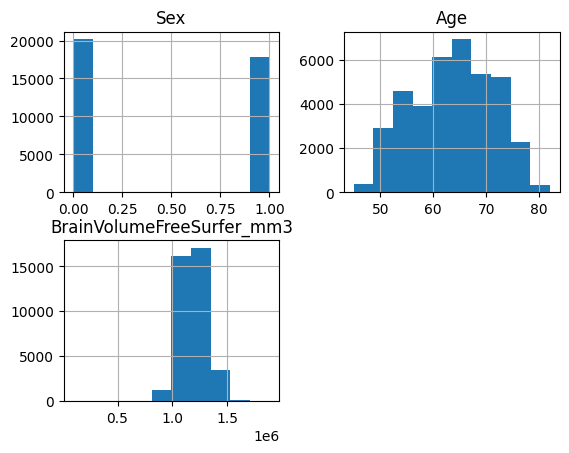

In [41]:
participants.hist()

In [42]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result

In [43]:
model_paths = get_model_paths(path_champollion)

In [44]:
model_paths[:5]

['/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1']

In [62]:
def compute(model_path):
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)

    # Residualizes
    phenotypes_cols = embeddings.columns
    merged = participants[covariates].merge(embeddings, left_index=True, right_index=True)
    resid_df = merged[covariates].copy()
    resid_df.loc[:, phenotypes_cols] = 0.0
    for dim_i in phenotypes_cols:
        X = merged[covariates]
        y = merged[dim_i]
        model = sm.OLS(y, X).fit()
        residuals = model.resid
        resid_df.loc[:, dim_i] = residuals

    # Merge
    merged = participants[[label]].merge(resid_df[phenotypes_cols], left_index=True, right_index=True)
    
    # Classifies
    X = merged.drop([label], axis=1)
    Y = merged[[label]]
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X)
    df2 = X.copy()

    # Makes OLS
    df2 = sm.add_constant(df2)
    model = sm.OLS(Y[label], df2)
    results = model.fit()
    f_value = results.fvalue
    p_value = results.f_pvalue

    # df = Y.copy()
    # df["predicted"] = df2.dot(results.params)
    # # predicted = pd.DataFrame(model.predict(results.params), columns=["predicted"])
    # # predicted = sm.add_constant(predicted)
    # # predicted.index = Y.index
    # # print(predicted[:5])
    # results = sm.OLS(df[label], 2*df["predicted"]).fit()

    # print(results.summary())
    
    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(f_value)
    
    # Returns result
    return (region, f_value, p_value, model_name, region_path, model_path)

In [63]:
result = []
for model_path in model_paths[:1]:
    result.append(compute(model_path))

Treating S.C.-sylv._left: SC-sylv_left/11-43-38_2 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2
                                 OLS Regression Results                                
Dep. Variable:                    Sex   R-squared (uncentered):                   0.651
Model:                            OLS   Adj. R-squared (uncentered):              0.651
Method:                 Least Squares   F-statistic:                          3.650e+04
Date:                Tue, 24 Sep 2024   Prob (F-statistic):                        0.00
Time:                        13:42:44   Log-Likelihood:                         -10055.
No. Observations:               19605   AIC:                                  2.011e+04
Df Residuals:                   19604   BIC:                                  2.012e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                               

In [47]:
df = pd.DataFrame(result, columns=['region', 'f_value', 'p_value', 'model_name', 'region_path', 'model_path'])

In [48]:
df

,region,f_value,p_value,model_name,region_path,model_path
0,S.C.-sylv._left,39.629123,0.0,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...
1,S.C.-sylv._left,40.080225,0.0,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...
2,S.F.inter.-S.F.sup._left,36.284990,0.0,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...
3,S.T.i.-S.T.s.-S.T.pol._right,43.782416,0.0,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...
4,F.Coll.-S.Rh._right,53.030151,0.0,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...
...,...,...,...,...,...,...
72,S.F.inter.-S.F.sup._right,37.774023,0.0,09-33-02_1,SFinter-SFsup_right/09-33-02_1,/neurospin/dico/data/deep_folding/current/mode...
73,S.T.s._left,43.494174,0.0,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...
74,F.C.M.post.-S.p.C._right,37.892627,0.0,15-09-24_1,FCMpost-SpC_right/15-09-24_1,/neurospin/dico/data/deep_folding/current/mode...
75,ORBITAL_right,39.610290,0.0,15-53-41_191,ORBITAL_right/15-53-41_191,/neurospin/dico/data/deep_folding/current/mode...


In [49]:
df['side'] = df['region'].str.split('_').str[-1]

In [50]:
def plot_horizontal(res, region_name, ax, f_value, p_value, f2_value, visible, title):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=f_value, ascending=True)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=0.05, color='black', linestyle='-')
    ax.barh(res[region_name], res[f2_value], fill=True, color='lightgray')
    ax.errorbar(res[f_value], res[region_name], xerr=0, fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    # ax.set_xlim((0.3, 1.0))
    ax.set_title(title)


In [51]:
df.sort_values(by="f_value", ascending=False)

,region,f_value,p_value,model_name,region_path,model_path,side
16,F.Coll.-S.Rh._left,54.688205,0.0,09-45-57_0,FColl-SRh_left/09-45-57_0,/neurospin/dico/data/deep_folding/current/mode...,left
4,F.Coll.-S.Rh._right,53.030151,0.0,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...,right
19,F.C.L.p.-subsc.-F.C.L.a.-INSULA._right,52.726536,0.0,19-49-20_193,FCLp-subsc-FCLa-INSULA_right/19-49-20_193,/neurospin/dico/data/deep_folding/current/mode...,right
31,Sc.Cal.-S.Li._left,50.189540,0.0,09-28-12_0,ScCal-SLi_left/09-28-12_0,/neurospin/dico/data/deep_folding/current/mode...,left
59,F.C.L.p.-subsc.-F.C.L.a.-INSULA._left,50.018970,0.0,18-59-14_0,FCLp-subsc-FCLa-INSULA_left/18-59-14_0,/neurospin/dico/data/deep_folding/current/mode...,left
...,...,...,...,...,...,...,...
52,S.F.marginal-S.F.inf.ant._left,34.415645,0.0,17-49-19_0,SFmarginal-SFinfant_left/17-49-19_0,/neurospin/dico/data/deep_folding/current/mode...,left
25,CINGULATE_left,34.123551,0.0,16-58-04_1,2024-07-16/16-58-04_1,/neurospin/dico/data/deep_folding/current/mode...,left
26,CINGULATE_left,33.837323,0.0,16-58-04_0,2024-07-16/16-58-04_0,/neurospin/dico/data/deep_folding/current/mode...,left
20,OCCIPITAL_right,33.797846,0.0,18-05-00_1,OCCIPITAL_right/18-05-00_1,/neurospin/dico/data/deep_folding/current/mode...,right


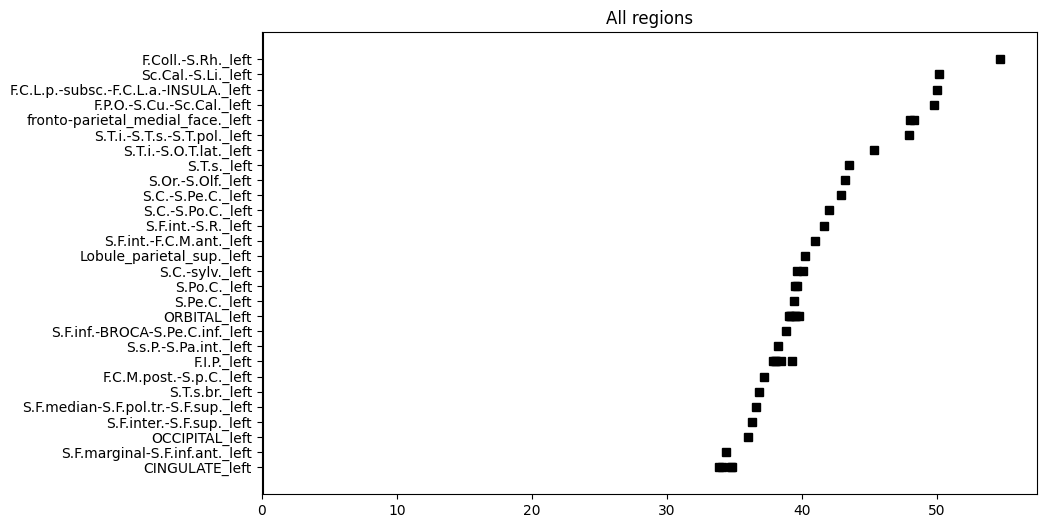

In [52]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='left'], "region", ax, "f_value", "f_value", "p_value",  True, "All regions")
plt.show()

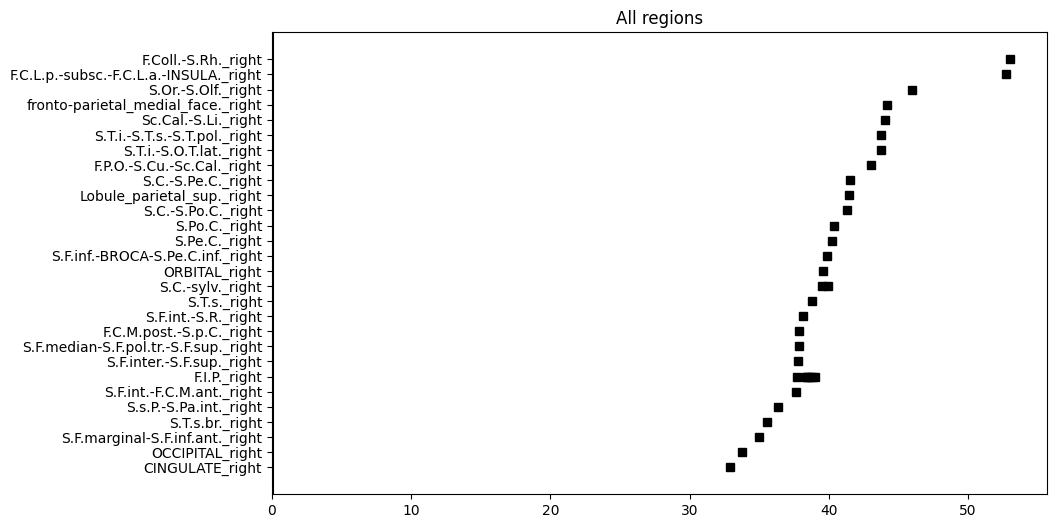

In [53]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='right'], "region", ax, "f_value", "p_value", "p_value",  True, "All regions")
plt.show()

In [54]:
df.sort_values("f_value")

,region,f_value,p_value,model_name,region_path,model_path,side
28,CINGULATE_right,32.923393,0.0,09-52-22_75,CINGULATE_right/09-52-22_75,/neurospin/dico/data/deep_folding/current/mode...,right
20,OCCIPITAL_right,33.797846,0.0,18-05-00_1,OCCIPITAL_right/18-05-00_1,/neurospin/dico/data/deep_folding/current/mode...,right
26,CINGULATE_left,33.837323,0.0,16-58-04_0,2024-07-16/16-58-04_0,/neurospin/dico/data/deep_folding/current/mode...,left
25,CINGULATE_left,34.123551,0.0,16-58-04_1,2024-07-16/16-58-04_1,/neurospin/dico/data/deep_folding/current/mode...,left
52,S.F.marginal-S.F.inf.ant._left,34.415645,0.0,17-49-19_0,SFmarginal-SFinfant_left/17-49-19_0,/neurospin/dico/data/deep_folding/current/mode...,left
...,...,...,...,...,...,...,...
59,F.C.L.p.-subsc.-F.C.L.a.-INSULA._left,50.018970,0.0,18-59-14_0,FCLp-subsc-FCLa-INSULA_left/18-59-14_0,/neurospin/dico/data/deep_folding/current/mode...,left
31,Sc.Cal.-S.Li._left,50.189540,0.0,09-28-12_0,ScCal-SLi_left/09-28-12_0,/neurospin/dico/data/deep_folding/current/mode...,left
19,F.C.L.p.-subsc.-F.C.L.a.-INSULA._right,52.726536,0.0,19-49-20_193,FCLp-subsc-FCLa-INSULA_right/19-49-20_193,/neurospin/dico/data/deep_folding/current/mode...,right
4,F.Coll.-S.Rh._right,53.030151,0.0,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...,right


In [55]:
df.to_csv(output_filename)